In [1]:
import gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
import time
import os

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def make_env():
    env = gym.make("Taxi-v3", render_mode="ansi")
    env.reset(seed=SEED)
    return env

class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_size)
        )

    def forward(self, x):
        return self.fc(x)

def train_dqn(episodes=1000, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.01,
              learning_rate=0.001, batch_size=64, memory_size=50000, target_update_freq=10):
    env = make_env()
    state_size = 1
    action_size = env.action_space.n

    policy_net = DQN(state_size, action_size).to(device)
    target_net = DQN(state_size, action_size).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    memory = deque(maxlen=memory_size)
    rewards = []

    for episode in range(episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0
        num_step = 0

        while not done:
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                state_tensor = torch.tensor([[state]], dtype=torch.float32).to(device)
                with torch.no_grad():
                    q_values = policy_net(state_tensor)
                action = torch.argmax(q_values).item()

            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            memory.append((state, action, reward, next_state, done))
            state = next_state
            total_reward += reward
            num_step += 1

            if len(memory) >= batch_size:
                minibatch = random.sample(memory, batch_size)
                states, actions, rewards_mb, next_states, dones = zip(*minibatch)

                states = torch.tensor(states, dtype=torch.float32).unsqueeze(1).to(device)
                actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1).to(device)
                rewards_mb = torch.tensor(rewards_mb, dtype=torch.float32).unsqueeze(1).to(device)
                next_states = torch.tensor(next_states, dtype=torch.float32).unsqueeze(1).to(device)
                dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(device)

                current_q = policy_net(states).gather(1, actions)
                next_q = target_net(next_states).max(1)[0].detach().unsqueeze(1)
                expected_q = rewards_mb + gamma * next_q * (1 - dones)

                loss = nn.MSELoss()(current_q, expected_q)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        rewards.append(total_reward)
        avg_reward = total_reward / num_step

        if episode % target_update_freq == 0:
            print('Episode', episode, 'rewards (latest):', total_reward, 'avg_reward:', avg_reward)
            target_net.load_state_dict(policy_net.state_dict())

    env.close()
    return rewards, policy_net

def play_policy_dqn(policy_net, episodes=3):
    env = make_env()
    for ep in range(episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        print(f"\nEpisode {ep+1}")
        time.sleep(1)

        while not done:
            os.system('clear')
            print(env.render())

            state_tensor = torch.tensor([[state]], dtype=torch.float32).to(device)
            with torch.no_grad():
                q_values = policy_net(state_tensor)
            action = torch.argmax(q_values).item()

            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            total_reward += reward
            state = next_state

            time.sleep(0.5)

        print(f"Episode finished with reward: {total_reward}")
        time.sleep(2)
    env.close()

Using device: cuda


In [2]:
episodes = 2000

print("Training DQN...")
rewards_dqn, policy_net_dqn = train_dqn(episodes=episodes)

np.save("rewards_dqn.npy", rewards_dqn)

torch.save(policy_net_dqn.state_dict(), "policy_net_dqn.pth")


Training DQN...


/home/jina/anaconda3/envs/brain_sub/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0 rewards (latest): -821 avg_reward: -4.105
Episode 10 rewards (latest): -776 avg_reward: -3.88
Episode 20 rewards (latest): -866 avg_reward: -4.33
Episode 30 rewards (latest): -794 avg_reward: -3.97
Episode 40 rewards (latest): -911 avg_reward: -4.555
Episode 50 rewards (latest): -740 avg_reward: -3.7
Episode 60 rewards (latest): -587 avg_reward: -2.935
Episode 70 rewards (latest): -587 avg_reward: -2.935
Episode 80 rewards (latest): -569 avg_reward: -2.845
Episode 90 rewards (latest): -578 avg_reward: -2.89
Episode 100 rewards (latest): -497 avg_reward: -2.485
Episode 110 rewards (latest): -587 avg_reward: -2.935
Episode 120 rewards (latest): -614 avg_reward: -3.07
Episode 130 rewards (latest): -443 avg_reward: -2.215
Episode 140 rewards (latest): -524 avg_reward: -2.62
Episode 150 rewards (latest): -398 avg_reward: -1.99
Episode 160 rewards (latest): -479 avg_reward: -2.395
Episode 170 rewards (latest): -506 avg_reward: -2.53
Episode 180 rewards (latest): -398 avg_reward: -1


Testing DQN

Episode 1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |

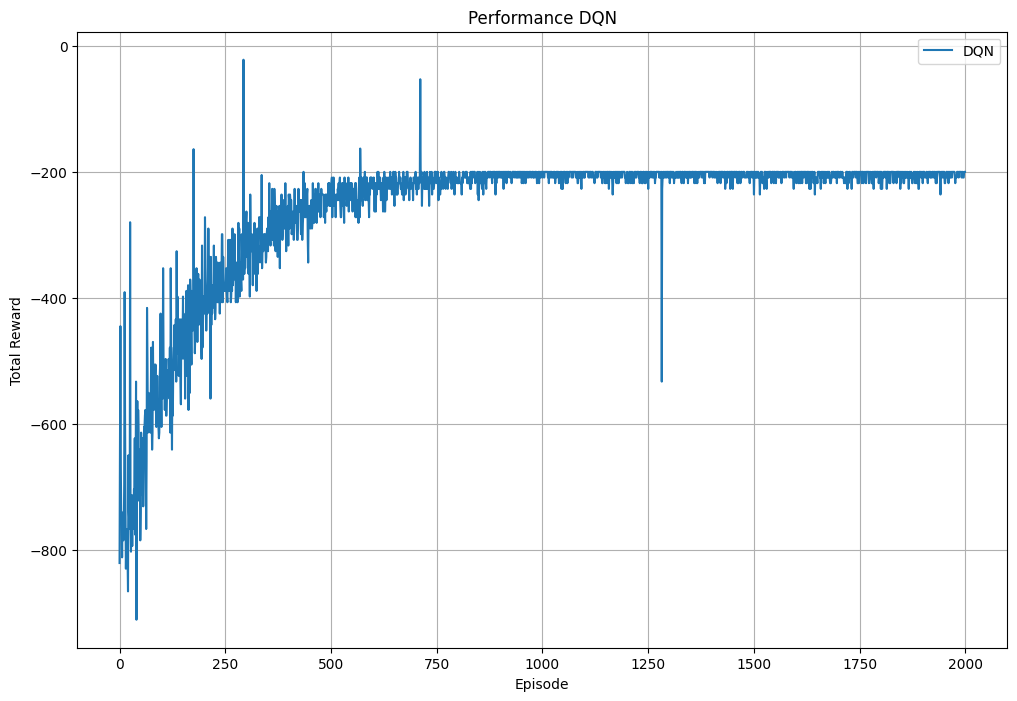


Final 100 Episodes Average Rewards:
DQN: -204.50


In [3]:
print("\nTesting DQN")
play_policy_dqn(policy_net_dqn)

plt.figure(figsize=(12, 8))
plt.plot(rewards_dqn, label="DQN")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Performance DQN")
plt.legend()
plt.grid()
plt.show()

print("\nFinal 100 Episodes Average Rewards:")
print(f"DQN: {np.mean(rewards_dqn[-100:]):.2f}")


### DQN deoesn't work well because the state doesn't contain the wall info

### 1. Without Wall info : preprocess_state (original taxi env state information)

In [4]:
import gym
import numpy as np

def preprocess_state(state, env):
    row, col, pass_loc, dest_idx = env.unwrapped.decode(state)
    
    print('row ', row)
    print('col ', col)
    print('pass_loc ', pass_loc)
    print('dest_idx ', dest_idx)
    row_onehot = np.eye(5)[row]          # 5-dim
    col_onehot = np.eye(5)[col]           # 5-dim
    passloc_onehot = np.eye(5)[pass_loc]  # 5-dim
    dest_onehot = np.eye(4)[dest_idx]     # 4-dim

    state_vec = np.concatenate([row_onehot, col_onehot, passloc_onehot, dest_onehot])  # shape (19,)
    return state_vec

env = gym.make("Taxi-v3")
env.reset(seed=42)

state, _ = env.reset()
print(f"Original state (integer): {state}")

state_features = preprocess_state(state, env)

print("\nPreprocessed state vector:")
print(state_features)
print(f"Shape: {state_features.shape}")

env.close()


Original state (integer): 214
row  2
col  0
pass_loc  3
dest_idx  2

Preprocessed state vector:
[0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
Shape: (19,)


### 2. With wall info : preprocess_state_with_walls (our modified state information)

In [5]:
def preprocess_state_with_walls(state, env):
    row, col, pass_loc, dest_idx = env.unwrapped.decode(state)

    row_onehot = np.eye(5)[row]
    col_onehot = np.eye(5)[col]
    passloc_onehot = np.eye(5)[pass_loc]
    dest_onehot = np.eye(4)[dest_idx]

    wall_north = 1 if row == 0 else 0
    wall_south = 1 if row == 4 else 0
    wall_west = 1 if col == 0 else 0
    wall_east = 1 if col == 4 else 0

    if (row == 0 or row == 1) and col == 1:
        wall_east = 1
    if (row == 3 or row == 4) and (col ==0 or col == 2) :
        wall_east = 1
    if (row == 3 or row == 4) and (col == 1 or col == 3):
        wall_west = 1
    if (row == 0 or row == 1) and col == 2:
        wall_west = 1

    wall_info = np.array([wall_north, wall_south, wall_east, wall_west], dtype=np.float32)

    state_vec = np.concatenate([row_onehot, col_onehot, passloc_onehot, dest_onehot, wall_info])

    return state_vec


In [6]:
def train_dqn_with_walls(episodes=1000, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.01,
              learning_rate=0.001, batch_size=64, memory_size=50000, target_update_freq=10):
    env = make_env()
    
    # Updated state size: 5+5+5+4+4 = 23
    state_size = 23
    action_size = env.action_space.n

    policy_net = DQN(state_size, action_size).to(device)
    target_net = DQN(state_size, action_size).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    memory = deque(maxlen=memory_size)
    rewards = []

    for episode in range(episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0
        num_step = 0

        while not done:
            state_features = preprocess_state_with_walls(state, env)
            state_tensor = torch.tensor([state_features], dtype=torch.float32).to(device)

            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    q_values = policy_net(state_tensor)
                action = torch.argmax(q_values).item()

            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            memory.append((state, action, reward, next_state, done))
            state = next_state
            total_reward += reward
            num_step += 1

            if len(memory) >= batch_size:
                minibatch = random.sample(memory, batch_size)
                states, actions, rewards_mb, next_states, dones = zip(*minibatch)

                states_features = np.array([preprocess_state_with_walls(s, env) for s in states])
                next_states_features = np.array([preprocess_state_with_walls(ns, env) for ns in next_states])

                states_tensor = torch.tensor(states_features, dtype=torch.float32).to(device)
                next_states_tensor = torch.tensor(next_states_features, dtype=torch.float32).to(device)
                actions_tensor = torch.tensor(actions, dtype=torch.int64).unsqueeze(1).to(device)
                rewards_tensor = torch.tensor(rewards_mb, dtype=torch.float32).unsqueeze(1).to(device)
                dones_tensor = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(device)

                current_q = policy_net(states_tensor).gather(1, actions_tensor)
                next_q = target_net(next_states_tensor).max(1)[0].detach().unsqueeze(1)
                expected_q = rewards_tensor + gamma * next_q * (1 - dones_tensor)

                loss = nn.MSELoss()(current_q, expected_q)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        rewards.append(total_reward)
        avg_reward = total_reward / num_step

        if episode % target_update_freq == 0:
            print('Episode', episode, 'rewards (latest):', total_reward, 'avg_reward:', avg_reward)
            target_net.load_state_dict(policy_net.state_dict())

    env.close()
    return rewards, policy_net


In [7]:
print("Training DQN with Walls...")
rewards_dqn_with_walls, policy_net_dqn_with_walls = train_dqn_with_walls(episodes=episodes)

Training DQN with Walls...


/tmp/ipykernel_3386485/541131864.py:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  state_tensor = torch.tensor([state_features], dtype=torch.float32).to(device)


Episode 0 rewards (latest): -677 avg_reward: -4.284810126582278
Episode 10 rewards (latest): -722 avg_reward: -3.61
Episode 20 rewards (latest): -668 avg_reward: -3.34
Episode 30 rewards (latest): -650 avg_reward: -3.25
Episode 40 rewards (latest): -668 avg_reward: -3.34
Episode 50 rewards (latest): -650 avg_reward: -3.25
Episode 60 rewards (latest): -74 avg_reward: -2.3125
Episode 70 rewards (latest): -77 avg_reward: -2.2
Episode 80 rewards (latest): -560 avg_reward: -2.8
Episode 90 rewards (latest): -614 avg_reward: -3.07
Episode 100 rewards (latest): -515 avg_reward: -2.575
Episode 110 rewards (latest): -336 avg_reward: -2.24
Episode 120 rewards (latest): -533 avg_reward: -2.665
Episode 130 rewards (latest): -497 avg_reward: -2.485
Episode 140 rewards (latest): -313 avg_reward: -2.0324675324675323
Episode 150 rewards (latest): -56 avg_reward: -1.3658536585365855
Episode 160 rewards (latest): -497 avg_reward: -2.485
Episode 170 rewards (latest): -199 avg_reward: -1.6446280991735538
E

In [8]:
def play_policy_dqn_with_walls(policy_net, episodes=3):
    env = make_env()
    for ep in range(episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        print(f"\nEpisode {ep+1}")
        time.sleep(1)

        while not done:
            os.system('clear')  # or 'cls' if you are on Windows
            print(env.render())

            state_features = preprocess_state_with_walls(state, env)
            state_tensor = torch.tensor([state_features], dtype=torch.float32).to(device)

            with torch.no_grad():
                q_values = policy_net(state_tensor)
            action = torch.argmax(q_values).item()

            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            total_reward += reward
            state = next_state

            time.sleep(0.5)

        print(f"Episode finished with reward: {total_reward}")
        time.sleep(2)
    env.close()


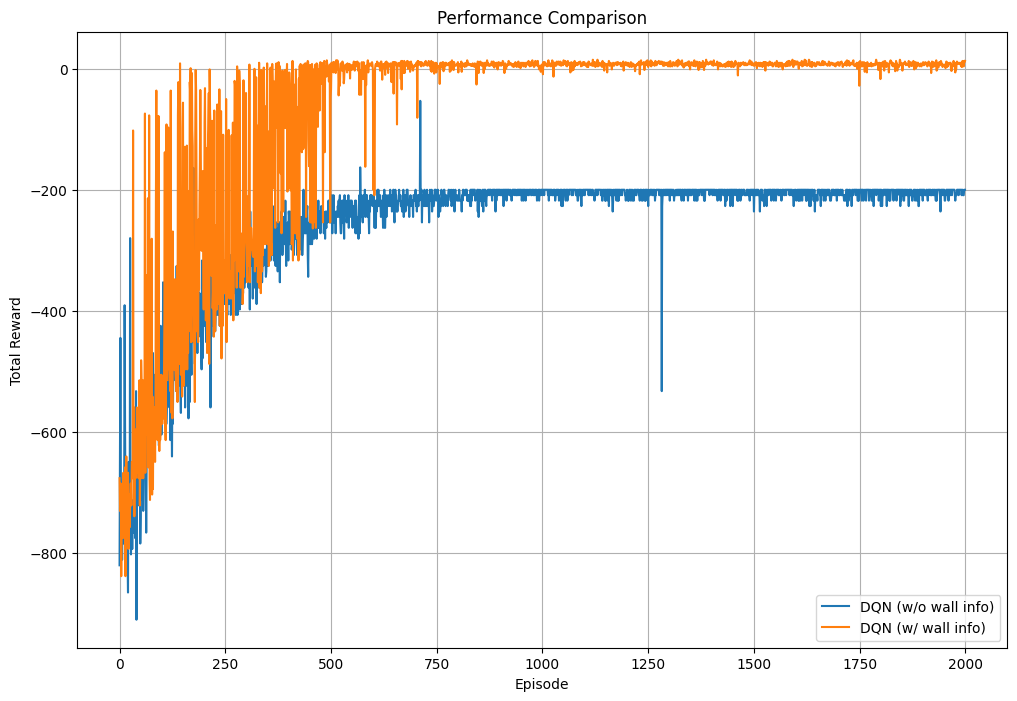


Final 100 Episodes Average Rewards:
DQN (w/o wall info): -204.50
DQN (w/ wall info): 7.04


In [9]:
plt.figure(figsize=(12, 8))
plt.plot(rewards_dqn, label="DQN (w/o wall info)")
plt.plot(rewards_dqn_with_walls, label="DQN (w/ wall info)")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Performance Comparison")
plt.legend()
plt.grid()
plt.show()

print("\nFinal 100 Episodes Average Rewards:")
print(f"DQN (w/o wall info): {np.mean(rewards_dqn[-100:]):.2f}")
print(f"DQN (w/ wall info): {np.mean(rewards_dqn_with_walls[-100:]):.2f}")

In [10]:
print("\nTesting DQN-Wall")
play_policy_dqn_with_walls(policy_net_dqn_with_walls)


Testing DQN-Wall

Episode 1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : |_: |
|Y| : |B: |
+---------+
  (North)

+---------+
|R: | : :G|
| : | : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (North)

+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

+---------+
|R: | : :G|
| : | : :

### DQN with wall info converges while DQN without wall info doesn't.